In [ ]:
!nvidia-smi

Fri Apr 30 23:12:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 install mxnet-cu101

     |████████████████████████████████| 356.7MB 45kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import numpy as np
import mxnet as mx

import time

In [ ]:
x_mx_cpu = mx.np.random.rand(1000, 1000, ctx = mx.cpu())
start_time = time.time()
mx.np.dot(x_mx_cpu, x_mx_cpu).wait_to_read() 
print("Time of the operation: ", time.time() - start_time)

Time of the operation:  0.04673886299133301


In [ ]:
x_mx_cpu = mx.np.random.rand(1000, 1000, ctx = mx.cpu())
start_time = time.time()
x_2 = mx.np.dot(x_mx_cpu, x_mx_cpu)
print("(FAKE, MXNet has lazy evaluation)") 
print("Time of the operation : ", time.time() - start_time) 
start_time = time.time() 
print(x_2) 
print("(FAKE, MXNet has lazy evaluation)") 
print("Time to display: ", time.time() - start_time)

(FAKE, MXNet has lazy evaluation)
Time of the operation :  0.00118255615234375
[[256.59583 249.70404 249.48639 ... 251.97151 255.06744 255.60669]
 [255.22629 251.69475 245.7591  ... 252.78784 253.18878 247.78052]
 [257.54187 254.29262 251.76346 ... 261.0468  268.49127 258.2312 ]
 ...
 [256.9957  253.9823  249.59073 ... 256.7088  261.14255 253.37457]
 [255.94278 248.73282 248.16641 ... 254.39209 252.4108  249.02774]
 [253.3464  254.55524 250.00716 ... 253.15712 258.53894 255.18658]]
(FAKE, MXNet has lazy evaluation)
Time to display:  0.042133331298828125


In [ ]:
timings_np = {}
timings_mx_cpu = {}
timings_mx_gpu = {}
matrix_orders = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000]

In [ ]:
def create_matrix_np(n):
    """
    Given n, creates a squared n x n matrix,
    with each matrix value taken from a random
    uniform distribution between [0, 1].
    Returns the created matrix a.
    Uses NumPy.
    """
    a = np.random.rand(n, n)
    return a

def create_matrix_mx(n, ctx=mx.cpu()):
    """
    Given n, creates a squared n x n matrix,
    with each matrix value taken from a random
    uniform distribution between [0, 1].
    Returns the created matrix a.
    Uses MXNet NumPy syntax and Context ctx
    """
    a = mx.np.random.rand(n, n, ctx=ctx)
    a.wait_to_read()
    return a

In [ ]:
timings_np["create"] = []

for n in matrix_orders:
    result = %timeit -o create_matrix_np(n)
    timings_np["create"].append(result.best)

The slowest run took 222.53 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 988 ns per loop
The slowest run took 94.59 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.17 µs per loop
The slowest run took 34.22 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.69 µs per loop
The slowest run took 62.97 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 18.3 µs per loop
The slowest run took 7.28 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 69.6 µs per loop
1000 loops, best of 5: 1.86 ms per loop
100 loops, best of 5: 7.3 ms per loop
1 loop, best of 5: 178 ms per loop
1 loop, best of 5: 705 ms per loop


In [ ]:
timings_mx_cpu["create"] = []

for n in matrix_orders:
    result = %timeit -o create_matrix_mx(n)
    timings_mx_cpu["create"].append(result.best)

The slowest run took 51.94 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 140 µs per loop
The slowest run took 8.76 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 141 µs per loop
The slowest run took 4.27 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 141 µs per loop
The slowest run took 7.31 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 169 µs per loop
The slowest run took 5.57 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 251 µs per loop
100 loops, best of 5: 1.97 ms per loop
100 loops, best of 5: 7.32 ms per loop
10 loops, best of 5: 174 ms per loop
1 loop, best of 5: 694 ms per loop


In [ ]:
timings_mx_gpu["create"] = []

ctx = mx.gpu()
for n in matrix_orders:
    result = %timeit -o create_matrix_mx(n, ctx)
    timings_mx_gpu["create"].append(result.best)

The slowest run took 11346.40 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 215 µs per loop
1000 loops, best of 5: 199 µs per loop
The slowest run took 5.91 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 207 µs per loop
The slowest run took 4.09 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 206 µs per loop
The slowest run took 4.79 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 201 µs per loop
The slowest run took 4.88 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 214 µs per loop
The slowest run took 5.07 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 312 µs per loop
100 loops, best of 

In [ ]:
def multiply_matrix_np(a, b):
    """
    Multiples 2 squared matrixes a and b
    and returns the result c.
    Uses NumPy.
    """
    #c = np.matmul(a, b)
    c = np.dot(a, b)
    return c

def multiply_matrix_mx(a, b):
    """
    Multiples 2 squared matrixes a and b
    and returns the result c.
    Uses MXNet NumPy syntax.
    """
    c = mx.np.dot(a, b)
    c.wait_to_read()
    return c

In [ ]:
timings_np["multiply"] = []

for n in matrix_orders:
    a = create_matrix_np(n)
    b = create_matrix_np(n)

    result = %timeit -o multiply_matrix_np(a, b)
    timings_np["multiply"].append(result.best)

The slowest run took 33.86 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.08 µs per loop
The slowest run took 4262.18 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.28 µs per loop
The slowest run took 11.03 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.52 µs per loop
The slowest run took 5.89 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 12.3 µs per loop
The slowest run took 41.78 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 86.5 µs per loop
100 loops, best of 5: 6.78 ms per loop
10 loops, best of 5: 51.1 ms per loop
1 loop, best of 5: 6.12 s per loop
1 loop, best of 5: 48.8 s per loop


In [ ]:
timings_mx_cpu["multiply"] = []

for n in matrix_orders:
    a = create_matrix_mx(n)
    b = create_matrix_mx(n)

    result = %timeit -o multiply_matrix_mx(a, b)
    timings_mx_cpu["multiply"].append(result.best)

The slowest run took 5.97 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 63 µs per loop
10000 loops, best of 5: 62.1 µs per loop
10000 loops, best of 5: 66.8 µs per loop
10000 loops, best of 5: 86.6 µs per loop
10000 loops, best of 5: 167 µs per loop
100 loops, best of 5: 3.42 ms per loop
10 loops, best of 5: 25.4 ms per loop
1 loop, best of 5: 3.21 s per loop
1 loop, best of 5: 25.9 s per loop


In [ ]:
timings_mx_gpu["multiply"] = []

ctx = mx.gpu()
for n in matrix_orders:
    a = create_matrix_mx(n, ctx)
    b = create_matrix_mx(n, ctx)

    result = %timeit -o multiply_matrix_mx(a, b)
    timings_mx_gpu["multiply"].append(result.best)

The slowest run took 4.25 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 120 µs per loop
10000 loops, best of 5: 123 µs per loop
10000 loops, best of 5: 122 µs per loop
10000 loops, best of 5: 127 µs per loop
10000 loops, best of 5: 129 µs per loop
1000 loops, best of 5: 246 µs per loop
1000 loops, best of 5: 705 µs per loop
10 loops, best of 5: 64.6 ms per loop
1 loop, best of 5: 500 ms per loop


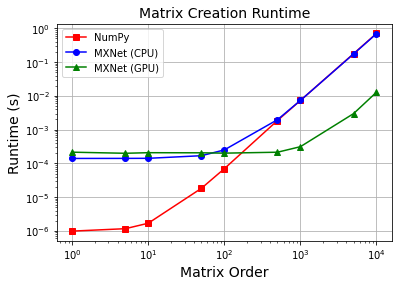

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(matrix_orders, timings_np["create"], color='red', marker='s')
plt.plot(matrix_orders, timings_mx_cpu["create"], color='blue', marker='o')
plt.plot(matrix_orders, timings_mx_gpu["create"], color='green', marker='^')
plt.title("Matrix Creation Runtime", fontsize=14)
plt.xlabel("Matrix Order", fontsize=14)
plt.ylabel("Runtime (s)", fontsize=14)
plt.grid(True)
ax = fig.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(["NumPy", "MXNet (CPU)", "MXNet (GPU)"])
plt.show()

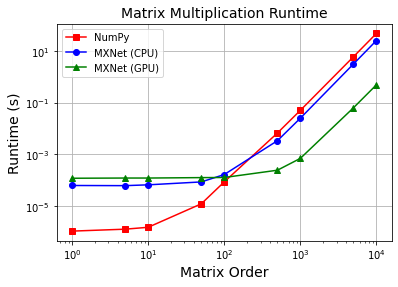

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(matrix_orders, timings_np["multiply"], color='red', marker='s')
plt.plot(matrix_orders, timings_mx_cpu["multiply"], color='blue', marker='o')
plt.plot(matrix_orders, timings_mx_gpu["multiply"], color='green', marker='^')
plt.title("Matrix Multiplication Runtime", fontsize=14)
plt.xlabel("Matrix Order", fontsize=14)
plt.ylabel("Runtime (s)", fontsize=14)
plt.grid(True)
ax = fig.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(["NumPy", "MXNet (CPU)", "MXNet (GPU)"])
plt.show()